In [30]:
import pandas as pd
from dotenv import dotenv_values, load_dotenv
import requests
import json
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# remove Umlauts in Ländername Österreich etc for filenames
#from unidecode import unidecode

In [4]:
pd.__version__

'2.1.1'

# Importe und Exporte von Strom – Deutschland und seine Nachbarn
API Zugriff auf die Datenbank Genesis-Online  
nach einem Tutorial von Simon Jockers  
https://github.com/sjockers/genesis-api-example

In [5]:
# Load credentials from .env file
load_dotenv()  
USERNAME, PASSWORD = dotenv_values().values()

# Set base path for API calls
BASE_URL = 'https://www-genesis.destatis.de/genesisWS/rest/2020/'

### Check login credentials

In [6]:
hello = requests.get(BASE_URL + 'helloworld/logincheck', params={
    'username': USERNAME,
    'password': PASSWORD,
    'language': 'en'
})
hello.json()["Status"]

'You have been logged in and out successfully!'

### Find by search term

In [7]:
search = requests.get(BASE_URL + 'find/find', params={
    'username': USERNAME,
    'password': PASSWORD,
    'language': 'de',
    'term': 'Elektrizität'
})
search_results = json.loads(search.text)
search_results['Status']

{'Code': 0, 'Content': 'erfolgreich', 'Type': 'Information'}

Show results (statistics):

In [8]:
pd.set_option('display.max_colwidth', None)

In [9]:
pd.DataFrame.from_dict(search_results['Statistics']).head()

,Code,Content,Cubes,Information
0,42131,Vierteljährliche Produktionserhebung i.Verarb.Gew.,18,true
1,43311,Monatserhebung ü. Elektrizitäts- u. Wärmeerzeugung,4,true
2,43312,Erh. ü.Stromein- u.-ausspeisung bei Netzbetreibern,4,true
3,43351,Erh.ü. Elektrizitäts- u.Wärmeerzeug. i.Verarb.Gew.,8,true
4,51000,Außenhandel,79,true


Show results (tables):

In [10]:
resultTables = pd.DataFrame.from_dict(search_results['Tables'])

In [11]:
resultTables[resultTables["Content"].str.contains("Ausfuhr")]

,Code,Content,Time
4,43312-0002,"Ein- und Ausfuhr von Elektrizität: Deutschland, Monate,\nLänder",
34,61421-0003,"Index der Ausfuhrpreise: Deutschland, Jahre,\nGüterverzeichnis (GP2009 2-/3-/4-Steller/Sonderpositionen)",
35,61421-0004,"Index der Ausfuhrpreise: Deutschland, Monate,\nGüterverzeichnis (GP2009 2-/3-/4-Steller/Sonderpositionen)",
36,61421-0005,"Index der Ausfuhrpreise: Deutschland, Jahre,\nGüterverzeichnis (GP2009 2-4-Steller Hierarchie)",
37,61421-0006,"Index der Ausfuhrpreise: Deutschland, Monate,\nGüterverzeichnis (GP2009 2-4-Steller Hierarchie)",
38,61421-0011,"Index der Ausfuhrpreise: Deutschland, Jahre,\nEuro-Länder und Nicht-Euro-Länder, Güterverzeichnis\n(GP2009 Sonderpositionen)",
39,61421-0012,"Index der Ausfuhrpreise: Deutschland, Monate,\nEuro-Länder und Nicht-Euro-Länder, Güterverzeichnis\n(GP2009 Sonderpositionen)",


In [12]:
#pd.reset_option('display.max_colwidth')

#### Load table

Load table in `ffcsv` ("Flat File CSV") format:

In [31]:
response = requests.get(BASE_URL + 'data/tablefile', params={
    'username': USERNAME,
    'password': PASSWORD,
    'name': '43312-0002',
    'startyear': 1990,
    'area': 'all',
    'compress': 'true',
    'format': 'ffcsv',
    'language': 'de'
})
print(response.text[0:120])

Statistik_Code;Statistik_Label;Zeit_Code;Zeit_Label;Zeit;1_Merkmal_Code;1_Merkmal_Label;1_Auspraegung_Code;1_Auspraegung


In [14]:
# Set encoding to unicode (utf-8)
response.encoding = 'utf-8'
csvInput = io.StringIO(response.text)

In [15]:
df = pd.read_csv(csvInput, delimiter=';', decimal=",", na_values=["...",".","-","/","x"])

In [18]:
staaten = df["2_Auspraegung_Label"].unique()
staaten

array(['Frankreich', 'Belgien und Luxemburg', 'Niederlande', 'Dänemark',
       'Schweiz', 'Österreich', 'Polen', 'Tschechien', 'Sonstige Länder',
       'Insgesamt'], dtype=object)

In [19]:
nachbarn = ['Insgesamt', 'Frankreich', 'Niederlande', 'Österreich', 'Tschechien', 'Polen', 'Belgien und Luxemburg', 'Sonstige Länder']

In [16]:
df["myTime"] = pd.to_datetime(pd.DataFrame({'year':df["Zeit"], 'month':df["3_Auspraegung_Code"].str[-2:], 'day':15}))

In [23]:
lastObservation = df.loc[(df["2_Auspraegung_Label"]=="Insgesamt") & \
                (df["SDO001__Austauschsaldo__MWh"].notna())]["myTime"].max()

In [24]:
lastObservation

Timestamp('2023-07-15 00:00:00')

In [29]:
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.titleweight'] = "bold"
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['svg.fonttype'] = 'none' # 'none' | 'path'
plt.rcParams['font.family'] = 'sans-serif' # 'Fira Sans' | 'sans-serif'

In [32]:
def drawChart(land):
    
    startyear=2013
    
    mydf = df[df["2_Auspraegung_Label"]==land]
    mydf = mydf[mydf["Zeit"]>=startyear]
    
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(16, 4))

    # Add x-axis and y-axis, convert to TWh
    ax.bar(mydf['myTime'], mydf['SDO001__Austauschsaldo__MWh']/1E6, width=31, color='#ccc', label="Saldo")

    ax.plot(mydf['myTime'], mydf['EKT102__Einfuhr_von_Elektrizitaet__MWh']/1E6, linewidth=2, label="Import")
    ax.plot(mydf['myTime'], mydf['EKT202__Ausfuhr_von_Elektrizitaet__MWh']/1E6, linewidth=2, label="Export")

    # Set title and labels for axes
    ax.set_title(land, pad=10)
    ax.set_ylabel(ylabel='Elektrizität (TWh)', labelpad=10)

    ax.set_xlim(pd.to_datetime(str(startyear)+"-01-01"), lastObservation + pd.DateOffset(months=1))
    
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))

    ax.tick_params(axis='x', which='major', length=20, labelsize=10)
    ax.tick_params(axis='x', which='minor', length= 3, labelsize=7)
   
    ax.yaxis.set_major_locator(ticker.FixedLocator([0]))
    ax.yaxis.set_minor_locator(ticker.MaxNLocator())
    ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
    ax.tick_params(axis='y', which='major', length=3, labelsize=9)
    ax.tick_params(axis='y', which='minor', length=3, labelsize=9)
    
    ax.grid(which='major', axis='x', color='#ddd', linewidth=0.5)
    ax.grid(which='major', axis='y', color='#333', linewidth=0.75)
    ax.grid(which='minor', axis='y', color='#ddd', linewidth=0.5)

    ax.legend(loc="upper left", bbox_to_anchor=(1.01, .9), facecolor="none", edgecolor="none")
    
    plt.box(False)
    plt.tight_layout()
    
    #my_land = unidecode(land).replace(" ", "_")
    #plt.savefig('img/'+my_land+'_Strom_ImportExport.svg', transparent=True)
    
    plt.show()

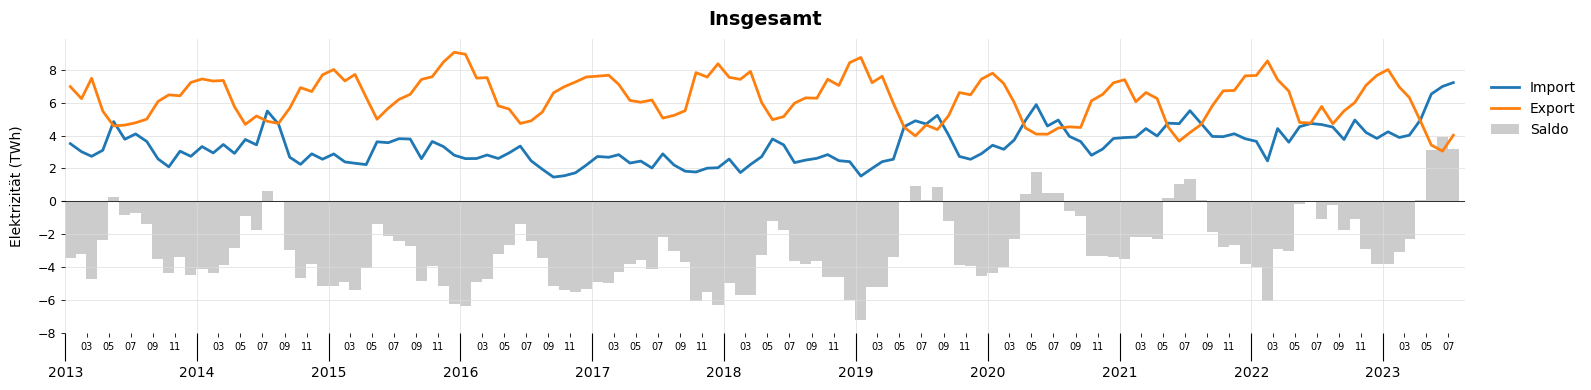

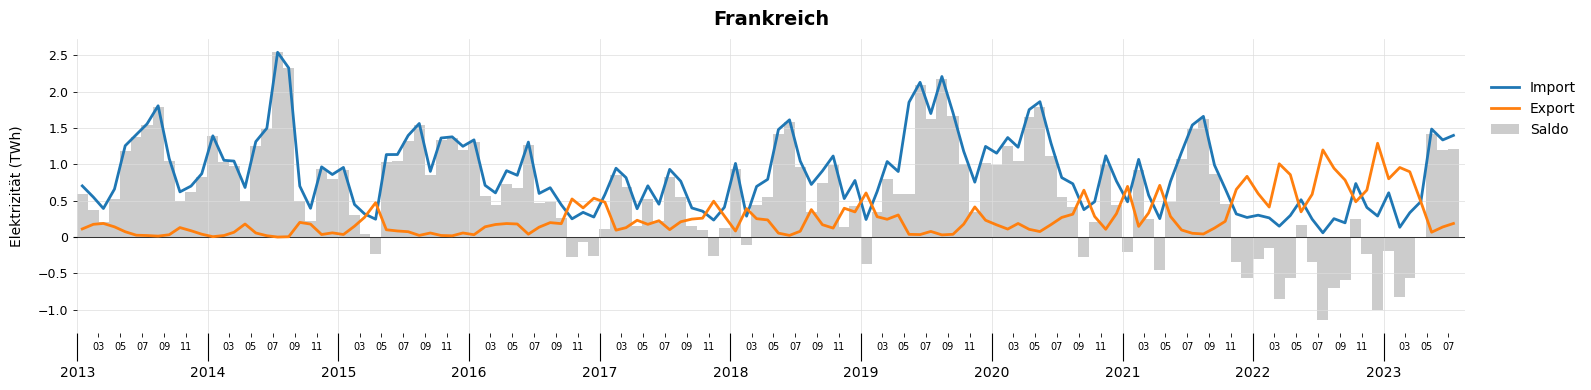

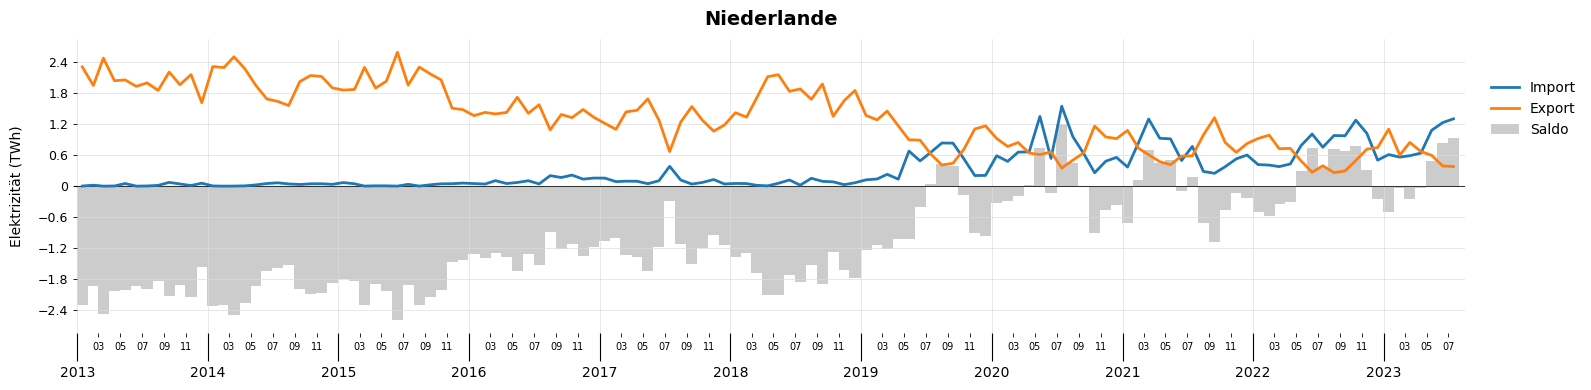

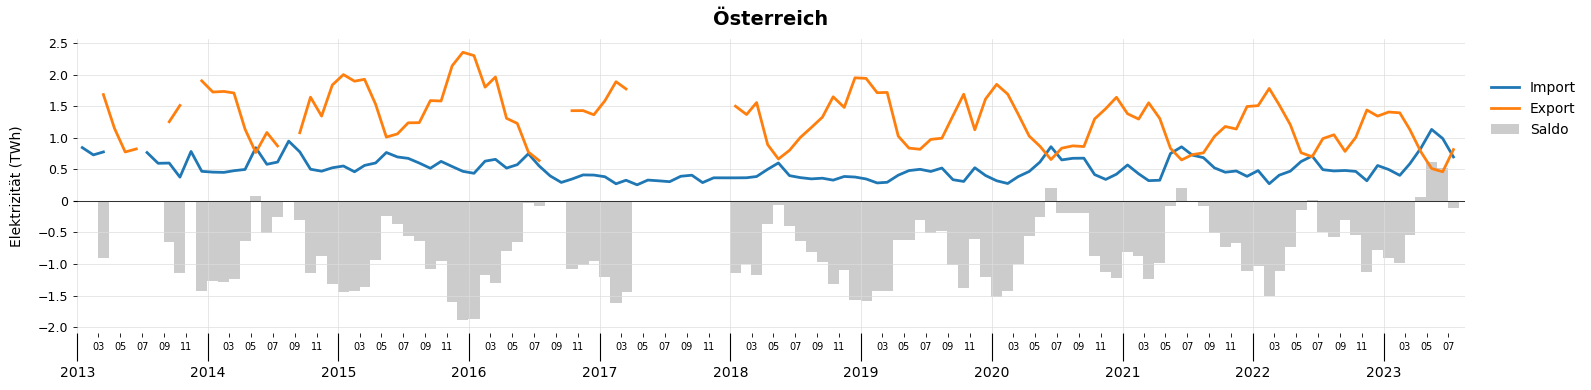

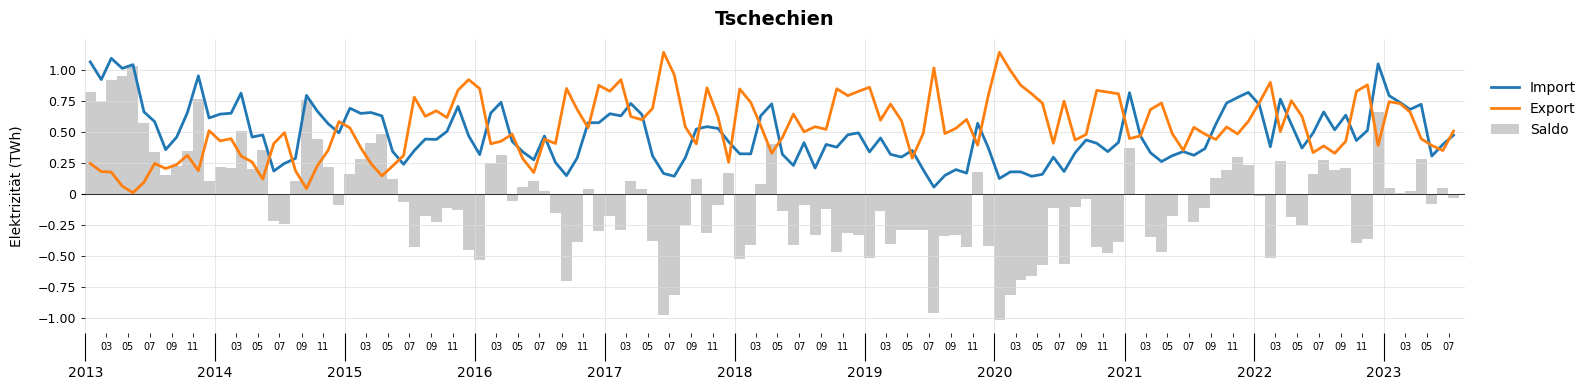

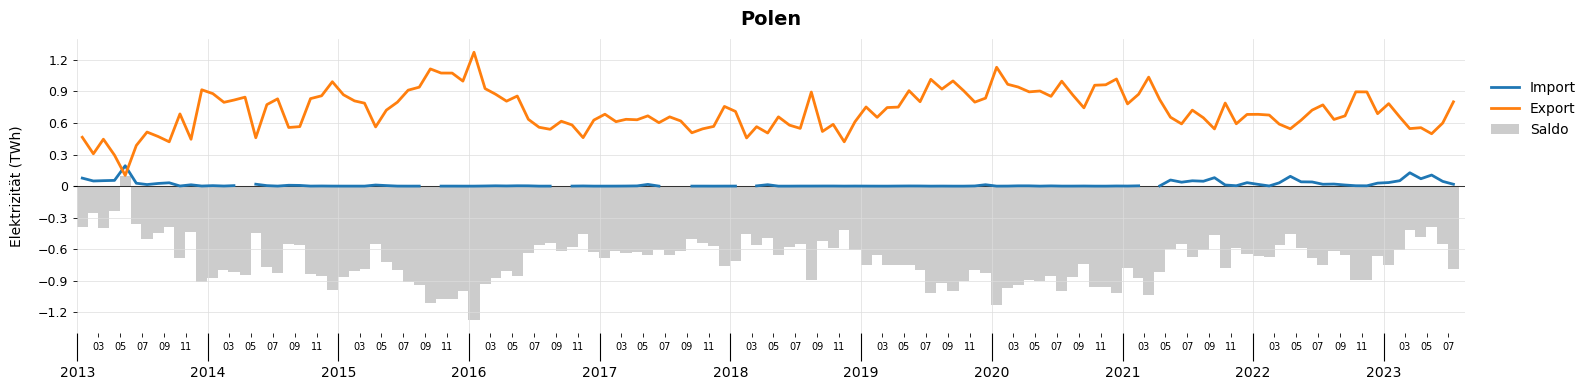

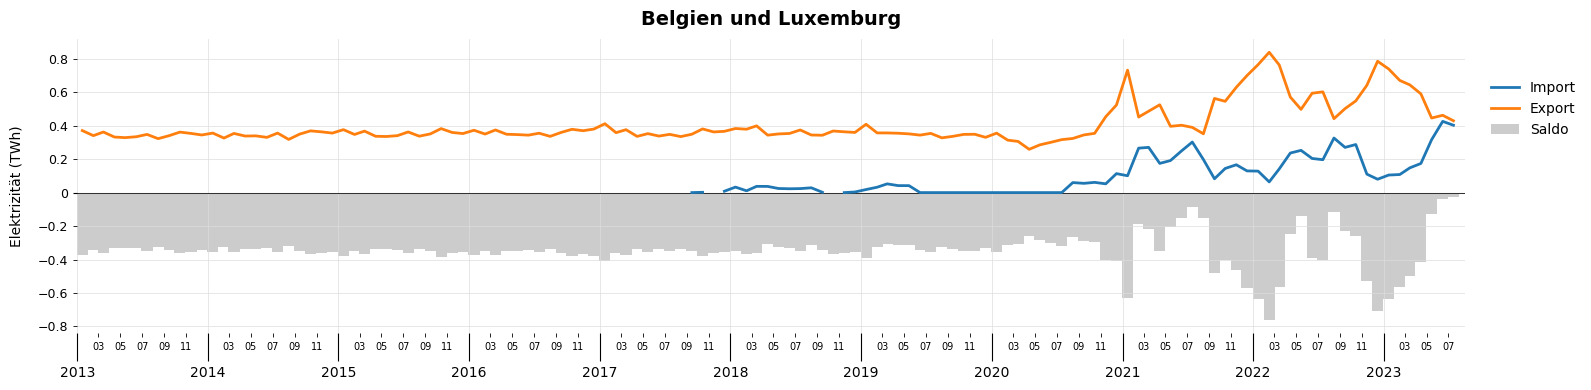

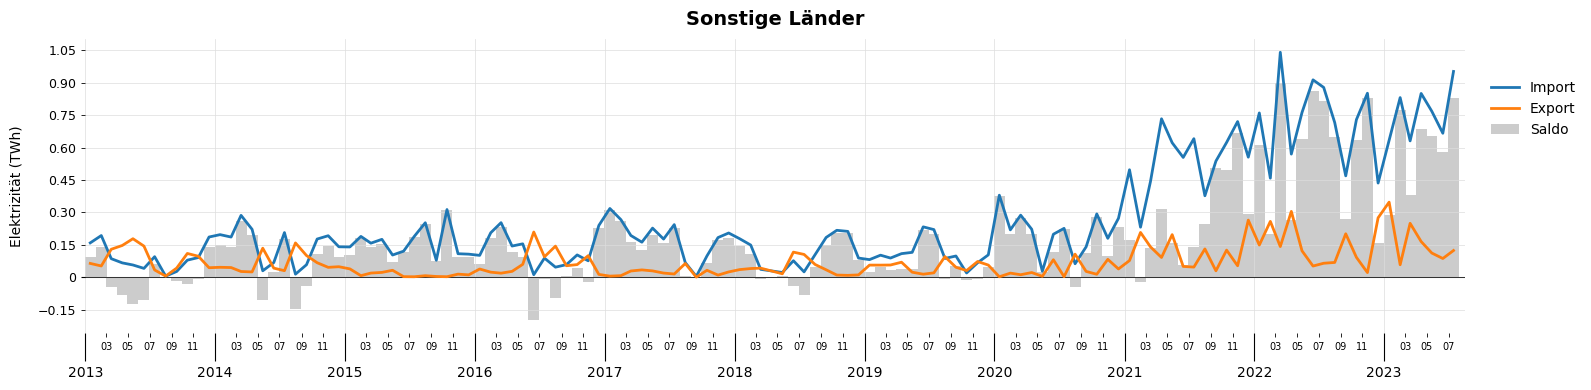

In [28]:
for nachbar in nachbarn:
    drawChart(nachbar)